# **An Neural Network example (y= x² + noise)**

## Data

In [1]:
#data
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

x=torch.linspace(-1, 1, steps=500).unsqueeze(1)
y=x**2 + 0.01*torch.randn_like(x)  #adding Gaussian noise to make the func more complicated
#this y is true value (used for finding the difference between prediction and y)

# PyTorch version

## train & test splitting

In [2]:
#train & test splitting for pytorch using sklearn
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)
#if we don't do the random_state it will collect the first majority of the data as train and the rest as test but now it will be choosen randomly

## Model

In [3]:
#Neural Network
model=nn.Sequential(
    #layer 1
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Dropout(0.1), #Drop 10% of outputs after relu
    #layer 2
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Dropout(0.1),
    #layer 3
    nn.Linear(16, 1))

#there's a rule for these numbers: more neurons -> more linear segmentations -> better curvature fit

## loss & optimizer

In [4]:
#loss(MSE) & optimizer(SGD)
loss_MSE=nn.MSELoss() #Mean Squared Error loss
optimizer=torch.optim.SGD(model.parameters(), lr=0.01) #Stochastic Gradient Descent

## training loop

In [5]:
#training loop
train_losslist=[]
test_losslist=[]
test_maelist=[]
epochlist=[]

for epoch in range(15000):
    #forward pass
    prediction=model(x_train)
    loss= loss_MSE(prediction, y_train)
    optimizer.zero_grad() #deleting the old gradients before computing a new one
    #backward pass
    loss.backward() #Backpropagating the loss 
    """Backpropagation propagates error gradients backward in the network (from the output to the input layer).
    it first start at the loss of final output and compute how much each w(weight) contributed to that loss by
    computing the gradients for each w (optimizer will use this gradients to update the w)"""
    optimizer.step() #updating based on the computed gradients 

    if epoch % 1000 ==0:
        #evaluating accuracy on test set (we aren't training(learning) so we stop the gradient taking process). we just observe the results in each epoch
        with torch.no_grad():
            test_preds= model(x_test)
            test_mae=torch.abs(test_preds - y_test).mean().item() #the metric (this helps us have an intution of how model is developing in time)
            test_loss=loss_MSE(test_preds, y_test).item() #loss on test data

        print(f"Epoch {epoch}: Train Loss={loss.item():.4f}, Test Loss={test_loss:.4f},  Test MAE(Metric)={test_mae:.4f}")
        last_mae=test_mae #memorising the last MAE computed to print later
        
        #needed for learning curve
        train_losslist.append(loss.item())
        test_losslist.append(test_loss)
        test_maelist.append(test_mae) #needed for learning intution of result
        epochlist.append(epoch)


Epoch 0: Train Loss=0.0876, Test Loss=0.1086,  Test MAE(Metric)=0.2664
Epoch 1000: Train Loss=0.0517, Test Loss=0.0672,  Test MAE(Metric)=0.2060
Epoch 2000: Train Loss=0.0255, Test Loss=0.0277,  Test MAE(Metric)=0.1342
Epoch 3000: Train Loss=0.0164, Test Loss=0.0261,  Test MAE(Metric)=0.1237
Epoch 4000: Train Loss=0.0159, Test Loss=0.0255,  Test MAE(Metric)=0.1155
Epoch 5000: Train Loss=0.0147, Test Loss=0.0153,  Test MAE(Metric)=0.0901
Epoch 6000: Train Loss=0.0134, Test Loss=0.0133,  Test MAE(Metric)=0.0812
Epoch 7000: Train Loss=0.0136, Test Loss=0.0162,  Test MAE(Metric)=0.0927
Epoch 8000: Train Loss=0.0120, Test Loss=0.0192,  Test MAE(Metric)=0.0966
Epoch 9000: Train Loss=0.0087, Test Loss=0.0216,  Test MAE(Metric)=0.0973
Epoch 10000: Train Loss=0.0094, Test Loss=0.0126,  Test MAE(Metric)=0.0782
Epoch 11000: Train Loss=0.0129, Test Loss=0.0173,  Test MAE(Metric)=0.0887
Epoch 12000: Train Loss=0.0086, Test Loss=0.0110,  Test MAE(Metric)=0.0747
Epoch 13000: Train Loss=0.0104, Test L

## the final computed MAE (metric)

In [6]:
#the final computed MAE (metric) after training (not the next unwritten step)
print(f"Last computed Test MAE(metric): {last_mae:.4f}")

Last computed Test MAE(metric): 0.0644


## Predicted vs True function plot

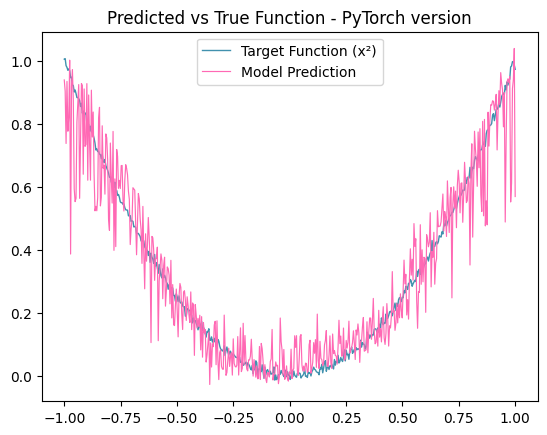

In [7]:
#model performance

plt.plot(x.numpy(), y.numpy(), label="Target Function (x²)",color="#4191AE", linewidth=1)
plt.plot(x.detach().numpy(), model(x).detach().numpy(), label="Model Prediction",color="hotpink", linewidth=0.85)
plt.legend()
plt.title("Predicted vs True Function - PyTorch version")
plt.show()

## learning curve (loss is MSE)

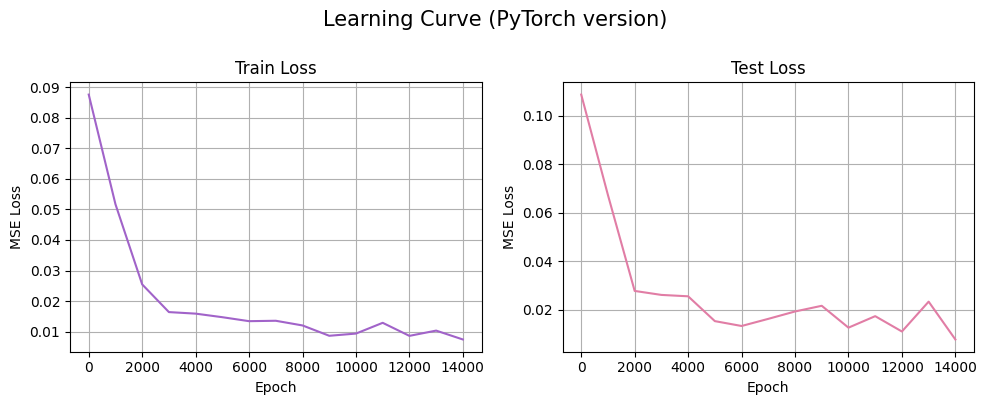

In [8]:
#learning curve (loss is MSE)

plt.figure(figsize=(10, 4))
plt.suptitle("Learning Curve (PyTorch version)", fontsize=15, y=1.00)

#Training loss
plt.subplot(1, 2, 1)
plt.plot(epochlist, train_losslist,color="#A163C9")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train Loss")
plt.grid(True)

#Test loss 
plt.subplot(1, 2, 2)
plt.plot(epochlist, test_losslist,color="#E17DA5")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Test Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


# Fastai version

## train & test splitting & dataloaders

In [9]:
#making the train & test data suitable for fastai(changing the format)

from fastai.vision.all import *
#converting tensors to numpy(py data type)
x_train_np, y_train_np=x_train.numpy(), y_train.numpy()
x_valid_np, y_valid_np=x_test.numpy(), y_test.numpy()

#fastai Datasets build dls with zips which pairs each x with its corresponding y(input, target)
train_ds=list(zip(x_train_np, y_train_np))
valid_ds=list(zip(x_valid_np, y_valid_np))

#DataLoaders
dls=DataLoaders.from_dsets(train_ds, valid_ds, bs=32)

## Model

In [10]:
#Neural Network
model1=nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Dropout(0.1), #it'll randomly drop 10% of outputs to 0 (to prevent overfitting)

    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Dropout(0.1),

    nn.Linear(16, 1))

#there's a rule for linear(,) numbers: more neurons -> more linear segmentations -> better curvature fit

## training (learner)

In [11]:
#training
learn=Learner(
    dls, model1,
    loss_func=MSELossFlat(),
    metrics=mae) 
learn.fit(15, lr=0.01)

PS=""" this is what (& why) we are doing:
decreasing train_loss: model fits the training data better
decreasing valid_loss: model is generalizing better
-------
fastai needed way less epochs than pytorch but why?
because as they say fastai like driving an automatic car while PyTorch is like driving a manual car 
which you can enhance but the fastai is quicker because:
fastai is highly optimized due to its mixed presision training & automatic learning rate """

epoch,train_loss,valid_loss,mae,time
0,0.131892,0.076810,0.225140,00:00
1,0.091129,0.029041,0.144890,00:00
2,0.065603,0.021068,0.104214,00:00
3,0.050590,0.002128,0.037519,00:00
4,0.039074,0.002702,0.042559,00:00
5,0.031257,0.004302,0.041658,00:00
6,0.025895,0.002302,0.034855,00:00
7,0.021910,0.002126,0.031843,00:00
8,0.018659,0.003300,0.041645,00:00
9,0.016746,0.001976,0.032159,00:00


## recording lossses & metric

In [12]:
#recording lossses & metric
train_losses=learn.recorder.losses #recording train_loss (per batch, not per epoch)
val_metrics=learn.recorder.values #recording validation metrics (val_loss & MAE) (per epoch)

#extracting loss and metrics from val_metrics
fastai_mae_only=[v[1] for v in val_metrics] #extracting the MAE (index=1) from val_losses 
epochsai=list(range(len(fastai_mae_only))) #creating a list of epoch numbers
val_losses_only= [v[0] for v in val_metrics]  #extracting the Val_loss(MSE) (index=0) from val_losses

## Predicted vs True function plot

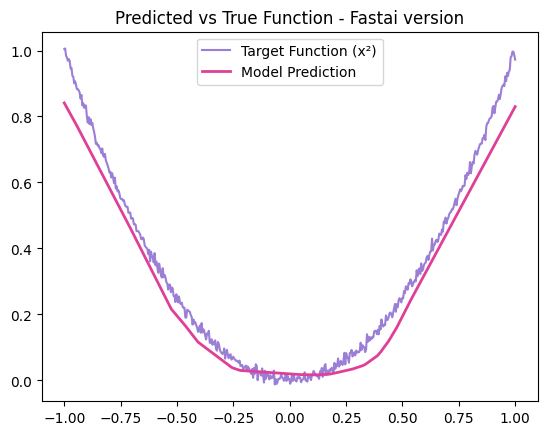

In [13]:
#Model performance
import matplotlib.pyplot as plt

plt.plot(x.numpy(), y.numpy(), label="Target Function (x²)",color="#9B7ED6", linewidth=1.5)
plt.plot(x.detach().numpy(), learn.model(x).detach().numpy(), label="Model Prediction",color="#DF3F97", linewidth=2)
plt.legend()
plt.title("Predicted vs True Function - Fastai version")
plt.show()

## learning curve (loss is MSE)

In [14]:
#changing the train loss per batch to per epoch
train_losses_perepoch = []
batches_per_epoch = len(learn.dls.train) #learn.dls.train is the fastai training dataLoader so it'll give the number of batch in a epoch

for i in range(len(train_losses)):
    if (i + 1) % batches_per_epoch==0: #continuing till the last epoch 
    #extracting last loss of that epoch to get the number from the tensor & storing it 
        train_losses_perepoch.append(train_losses[i].item())

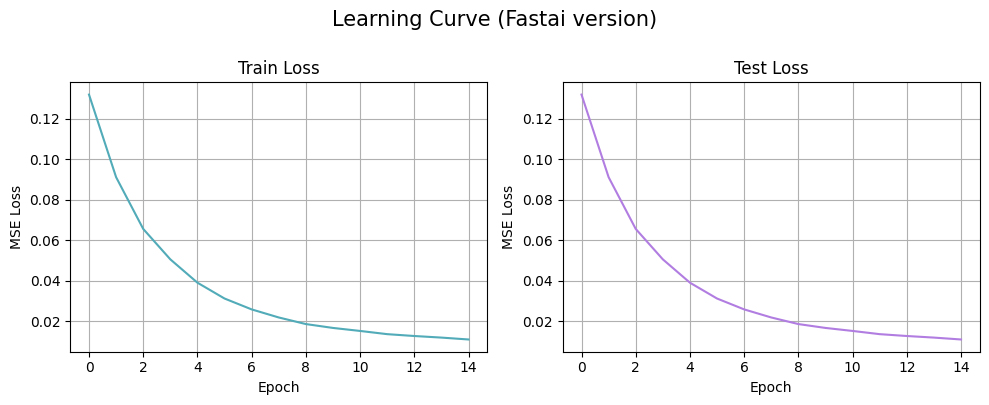

In [15]:
#learning curve (loss is MSE)

plt.figure(figsize=(10, 4))
plt.suptitle("Learning Curve (Fastai version)", fontsize=15, y=1.00)

#training loss
plt.subplot(1, 2, 1)
plt.plot(epochsai, train_losses_perepoch, color="#51ABB8")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train Loss")
plt.grid(True)

#test (validation) loss
plt.subplot(1, 2, 2)
plt.plot(epochsai, val_losses_only, color="#B17DE1")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Test Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


# Comparing

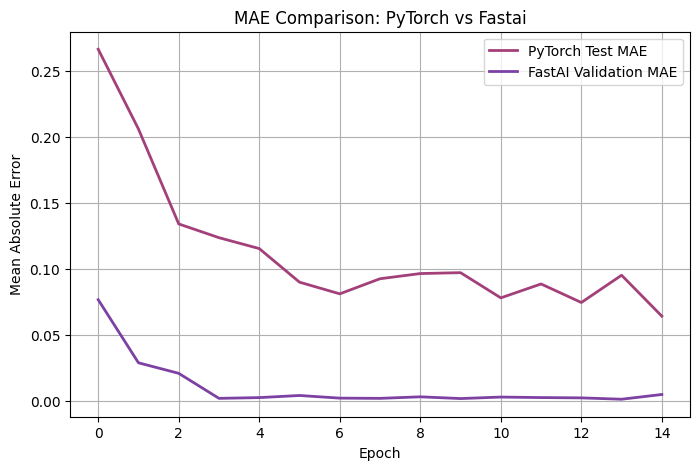

In [16]:
#comparing mae values of the two methods (it should be descending & the lower better)
plt.figure(figsize=(8, 5))
plt.plot(epochsai, test_maelist, label='PyTorch Test MAE',color="#A3407A", linewidth=2)
plt.plot(epochsai, fastai_mae_only, label='FastAI Validation MAE',color="#7C41A3", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("MAE Comparison: PyTorch vs Fastai")
plt.legend()
plt.grid(True)
plt.show()